## Load Packages

In [1]:
import pandas as pd
import numpy as np
from dvc.api import read, get_url
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib.pyplot import figure

## Part 1

Split the text into a table with each row representing a line of dialogue with columns for the speaker, line number, and the actual dialogue

In [2]:
# read in and open the text
txt = open('shakespeare.txt', 'r')
txt = txt.read()

In [3]:
# let's see what we're working with here by printing the first few lines
print(txt[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [4]:
# what does it look like not nearly formatted by print?
txt[:250]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n'

Based on what we've seen above what assumptions can we make about the text?
- Assumption 1: All new lines start with a capial letters
- Assumption 2: All sections are separated by a double new line
- Assumption 3: A colon followed by a space separates spakers from their dialogue
- Assumption 4: All documents follow the pattern "Speaker: Dialogue"

In [5]:
# save the first bit to test our assumptions since it's small and easy to work with 
test = txt[:250]

Our regex will require two capture groups- one for the speaker and the other for dialogue.

I assumed all lines begin with a capital but this is Shakespeare after all and he's prone to do anything (and if not then maybe there might be typos) so we'll allow the pattern to account for lowercase letters at the beginning of speaker names since our last assumption is that it follows the pattern "Speaker: Dialogue"

In [6]:
# put together regex pattern
patt = re.compile(
    "(?:\A|\n\n)"  # beginning of file or two newlines
    "(^[A-Z][\w ]+):$"  # Can start with Upper or lower case and ends with a colon
    "\n([\w\W]+?)"  # ANYTHING, but lazy (slightly modified from professor's code in slack but this is word/not a word instead of whitespace/not whitespace)
    "(?=\n\n|\Z)",  # until you hit two newlines or end-of-file
    flags=re.M
)

test_match = patt.findall(test)

In [7]:
# let's see if this works on our test set
test_df = pd.DataFrame(test_match, columns=['Speaker', 'Dialogue'])
test_df

,Speaker,Dialogue
0,First Citizen,"Before we proceed any further, hear me speak."
1,All,"Speak, speak."
2,First Citizen,You are all resolved rather to die than to fam...
3,All,Resolved. resolved.
4,First Citizen,"First, you know Caius Marcius is chief enemy t..."


It looks like our assumptions hold!

In [8]:
# next let's add the document line number

test_df["Line Number"] = np.arange(len(test_df))

# This starts at 0 so add 1
test_df["Line Number"] = test_df["Line Number"] + 1

# it works! 
test_df

,Speaker,Dialogue,Line Number
0,First Citizen,"Before we proceed any further, hear me speak.",1
1,All,"Speak, speak.",2
2,First Citizen,You are all resolved rather to die than to fam...,3
3,All,Resolved. resolved.,4
4,First Citizen,"First, you know Caius Marcius is chief enemy t...",5


In [9]:
# Apply what we've done above to the whole doucument
full_match = patt.findall(txt)
df = pd.DataFrame(full_match, columns=['Speaker', 'Dialogue'])
df["Line Number"] = np.arange(len(df))
df["Line Number"] = df["Line Number"] + 1
df

,Speaker,Dialogue,Line Number
0,First Citizen,"Before we proceed any further, hear me speak.",1
1,All,"Speak, speak.",2
2,First Citizen,You are all resolved rather to die than to fam...,3
3,All,Resolved. resolved.,4
4,First Citizen,"First, you know Caius Marcius is chief enemy t...",5
...,...,...,...
7102,ANTONIO,Nor I; my spirits are nimble.\nThey fell toget...,7103
7103,SEBASTIAN,"What, art thou waking?",7104
7104,ANTONIO,Do you not hear me speak?,7105
7105,SEBASTIAN,I do; and surely\nIt is a sleepy language and ...,7106


In [10]:
# there are still some random new line characters throughout so let's strip those for good measure
clean_lines = []
for line in df["Dialogue"]:
    clean_lines.append(line.replace("\n", " "))

df["Dialogue"] = clean_lines
df

,Speaker,Dialogue,Line Number
0,First Citizen,"Before we proceed any further, hear me speak.",1
1,All,"Speak, speak.",2
2,First Citizen,You are all resolved rather to die than to fam...,3
3,All,Resolved. resolved.,4
4,First Citizen,"First, you know Caius Marcius is chief enemy t...",5
...,...,...,...
7102,ANTONIO,Nor I; my spirits are nimble. They fell togeth...,7103
7103,SEBASTIAN,"What, art thou waking?",7104
7104,ANTONIO,Do you not hear me speak?,7105
7105,SEBASTIAN,I do; and surely It is a sleepy language and t...,7106


## Part 2

Determine the title of the play and add it as a 'Play' column to the table

My first assumption was that shakespeare wouldn't have have recurring characters so we could match plays by character. However, a quick google search proved this to be false so there goes that easy out. On the bright side, in looking this up  I found a kaggle dataset of shakespeare plays: https://www.kaggle.com/kingburrito666/shakespeare-plays

We can load this and cross reference the dialogue in this dataset with our smaller one

In [11]:
# load the full shakespeare dataset
Big_Shake = pd.read_csv('Shakespeare_data.csv')
Big_Shake

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"
...,...,...,...,...,...,...
111391,111392,A Winters Tale,38.0,5.3.180,LEONTES,"Lead us from hence, where we may leisurely"
111392,111393,A Winters Tale,38.0,5.3.181,LEONTES,Each one demand an answer to his part
111393,111394,A Winters Tale,38.0,5.3.182,LEONTES,Perform'd in this wide gap of time since first
111394,111395,A Winters Tale,38.0,5.3.183,LEONTES,We were dissever'd: hastily lead away.


In [12]:
# okay this is promising here we have the play lined up with each characters name and line
# first let's keep only what we need
Big_Shake.drop(columns=["Dataline", "ActSceneLine", "PlayerLinenumber"], inplace=True)

# before we join let's try to standardize as mich as we can by removing punctuation and making everything lowercase
# make both dfs lowercase
Big_Shake = Big_Shake.applymap(lambda s: s.lower() if type(s) == str else s)
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

# remove punctuation from both
Big_Shake = Big_Shake.applymap(lambda s: re.sub(r'[^\w\s]', '', s) if type(s) == str else s)
df = df.applymap(lambda s: re.sub(r'[^\w\s]', '', s) if type(s) == str else s)

# view the datasets to make sure everything looks right
Big_Shake

,Play,Player,PlayerLine
0,henry iv,NaN,act i
1,henry iv,NaN,scene i london the palace
2,henry iv,NaN,enter king henry lord john of lancaster the ea...
3,henry iv,king henry iv,so shaken as we are so wan with care
4,henry iv,king henry iv,find we a time for frighted peace to pant
...,...,...,...
111391,a winters tale,leontes,lead us from hence where we may leisurely
111392,a winters tale,leontes,each one demand an answer to his part
111393,a winters tale,leontes,performd in this wide gap of time since first
111394,a winters tale,leontes,we were disseverd hastily lead away


In [13]:
df

,Speaker,Dialogue,Line Number
0,first citizen,before we proceed any further hear me speak,1
1,all,speak speak,2
2,first citizen,you are all resolved rather to die than to famish,3
3,all,resolved resolved,4
4,first citizen,first you know caius marcius is chief enemy to...,5
...,...,...,...
7102,antonio,nor i my spirits are nimble they fell together...,7103
7103,sebastian,what art thou waking,7104
7104,antonio,do you not hear me speak,7105
7105,sebastian,i do and surely it is a sleepy language and th...,7106


Assumption prior to merge: If a documents matches both speaker and dialogue it must be from the same play

In [14]:
# okay let's try to join on dialogue
merged_df = df.merge(Big_Shake, how = "left", left_on = ["Dialogue", "Speaker"], right_on=["PlayerLine", "Player"])

merged_df


,Speaker,Dialogue,Line Number,Play,Player,PlayerLine
0,first citizen,before we proceed any further hear me speak,1,coriolanus,first citizen,before we proceed any further hear me speak
1,all,speak speak,2,coriolanus,all,speak speak
2,first citizen,you are all resolved rather to die than to famish,3,coriolanus,first citizen,you are all resolved rather to die than to famish
3,all,resolved resolved,4,coriolanus,all,resolved resolved
4,first citizen,first you know caius marcius is chief enemy to...,5,coriolanus,first citizen,first you know caius marcius is chief enemy to...
...,...,...,...,...,...,...
7164,antonio,nor i my spirits are nimble they fell together...,7103,NaN,NaN,NaN
7165,sebastian,what art thou waking,7104,the tempest,sebastian,what art thou waking
7166,antonio,do you not hear me speak,7105,the tempest,antonio,do you not hear me speak
7167,sebastian,i do and surely it is a sleepy language and th...,7106,NaN,NaN,NaN


In [15]:
# what didn't merge?

merged_df[merged_df['Play'].isna()]

# oh shoot there's a lot- this dind't work nearly as well as I hoped by maybe we can impute some

,Speaker,Dialogue,Line Number,Play,Player,PlayerLine
6,first citizen,let us kill him and well have corn at our own ...,7,NaN,NaN,NaN
9,first citizen,we are accounted poor citizens the patricians ...,10,NaN,NaN,NaN
13,first citizen,very well and could be content to give him goo...,14,NaN,NaN,NaN
15,first citizen,i say unto you what he hath done famously he d...,16,NaN,NaN,NaN
16,second citizen,what he cannot help in his nature you account ...,17,NaN,NaN,NaN
...,...,...,...,...,...,...
7159,antonio,we two my lord will guard your person while yo...,7098,NaN,NaN,NaN
7163,sebastian,why doth it not then our eyelids sink i find n...,7102,NaN,NaN,NaN
7164,antonio,nor i my spirits are nimble they fell together...,7103,NaN,NaN,NaN
7167,sebastian,i do and surely it is a sleepy language and th...,7106,NaN,NaN,NaN


Assumption for imputation: if the speaker is the same as two lines before (so in this case there would be active dialogue) let's assume that they're the same play

In [16]:
# impute
for i, row in merged_df.iterrows():
    if merged_df.loc[i,'Play'] is np.nan:
        if merged_df.loc[i,'Speaker'] == merged_df.loc[i-2,'Speaker']:  
            merged_df.loc[i,'Play'] =  merged_df.loc[i-2,'Play']

# that made a big difference!
merged_df[merged_df['Play'].isna()]

,Speaker,Dialogue,Line Number,Play,Player,PlayerLine
9,first citizen,we are accounted poor citizens the patricians ...,10,NaN,NaN,NaN
13,first citizen,very well and could be content to give him goo...,14,NaN,NaN,NaN
15,first citizen,i say unto you what he hath done famously he d...,16,NaN,NaN,NaN
17,first citizen,if i must not i need not be barren of accusati...,18,NaN,NaN,NaN
20,second citizen,worthy menenius agrippa one that hath always l...,21,NaN,NaN,NaN
...,...,...,...,...,...,...
7152,gonzalo,you are gentlemen of brave metal you would lif...,7091,NaN,NaN,NaN
7155,gonzalo,no i warrant you i will not adventure my discr...,7094,NaN,NaN,NaN
7157,alonso,what all so soon asleep i wish mine eyes would...,7096,NaN,NaN,NaN
7158,sebastian,please you sir do not omit the heavy offer of ...,7097,NaN,NaN,NaN


In [17]:
# can we do it backwards now? So if the speaker is the same as two lines after, we can assume that it is the same play
for i, row in merged_df.iterrows():
    if merged_df.loc[i,'Play'] is np.nan:
        if merged_df.loc[i,'Speaker'] == merged_df.loc[i+2,'Speaker']:  
            merged_df.loc[i,'Play'] = merged_df.loc[i+2,'Play']

# that made a big difference!
merged_df[merged_df['Play'].isna()]

,Speaker,Dialogue,Line Number,Play,Player,PlayerLine
9,first citizen,we are accounted poor citizens the patricians ...,10,NaN,NaN,NaN
13,first citizen,very well and could be content to give him goo...,14,NaN,NaN,NaN
15,first citizen,i say unto you what he hath done famously he d...,16,NaN,NaN,NaN
20,second citizen,worthy menenius agrippa one that hath always l...,21,NaN,NaN,NaN
22,menenius,what works my countrymen in hand where go you ...,23,NaN,NaN,NaN
...,...,...,...,...,...,...
7152,gonzalo,you are gentlemen of brave metal you would lif...,7091,NaN,NaN,NaN
7155,gonzalo,no i warrant you i will not adventure my discr...,7094,NaN,NaN,NaN
7157,alonso,what all so soon asleep i wish mine eyes would...,7096,NaN,NaN,NaN
7158,sebastian,please you sir do not omit the heavy offer of ...,7097,NaN,NaN,NaN


We were able to impute a singificant amount of the missing values. This imputation is based on the assumption that even if characters are reused they wouldn't be reused so frequently as to be within two lines of each other. Instead, if a character's lines are so close together they must be engaged in active dialogue and therefore it is the same play

In [18]:
# Our new dataset is largere than our original, why is that?
# let's see if there are duplicate dialogues

# here are our duplicates
merged_df[merged_df["Line Number"].duplicated(keep=False)]

,Speaker,Dialogue,Line Number,Play,Player,PlayerLine
324,brutus,whats the matter,325,coriolanus,brutus,whats the matter
325,brutus,whats the matter,325,julius caesar,brutus,whats the matter
533,citizens,down with him down with him,533,coriolanus,citizens,down with him down with him
534,citizens,down with him down with him,533,coriolanus,citizens,down with him down with him
559,citizens,down with him down with him,558,coriolanus,citizens,down with him down with him
...,...,...,...,...,...,...
6942,miranda,o the heavens,6883,the tempest,miranda,o the heavens
7047,alonso,prithee peace,6988,the tempest,alonso,prithee peace
7048,alonso,prithee peace,6988,the tempest,alonso,prithee peace
7121,alonso,prithee peace,7061,the tempest,alonso,prithee peace


Based on the above duplicates, we can assume that there are some plays where there are repeared characters- such as Coriolanus and Julius Caesar who use similar short lines. These then matched with each other in the merge, creating duplicates. The incomplete matches and duplicates show that while this method kind of worked, it was far from perfect

## Part 3

Determine how important or interesting a speaker is

Assumption 1: The person who speaks the most is the most important

In [19]:
# speaker frequency
counts = df["Speaker"].value_counts()[:10]
counts = pd.DataFrame(counts).reset_index().rename(columns={'index':'Speaker', 'Speaker':'Count'})

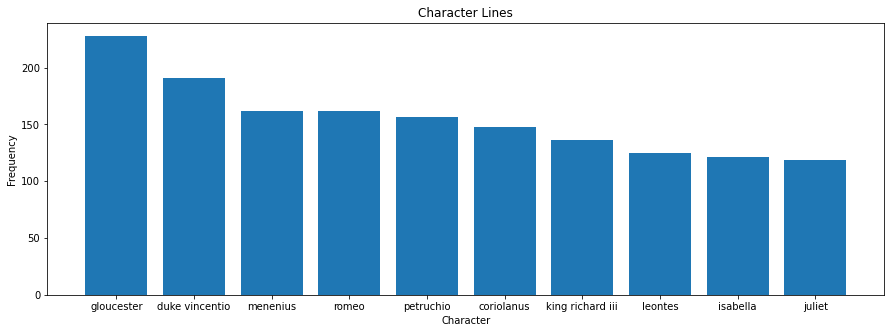

In [20]:
# let's plot the frequency
plt.figure(figsize=(15, 5))
plt.bar("Speaker", "Count", data = counts)
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.title("Character Lines")
plt.show()



I don't know who this gloucester fellow is but after some googling he seems to be a side character at best. This would imply that our frequency idea was not a very good one

New assumption: Maybe it's not how much you talk but what you say. Let's see if we can determine importance by which characters use keywords the most

In [21]:
# list of stopwords I copied off this github comment because it had words like thou: https://gist.github.com/sebleier/554280?permalink_comment_id=3059054#gistcomment-3059054
# I then tweaked it a little more for this dataset
stopwords = ['thee', 'hath', 'should', 'tis', 'man', 'she',"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "A", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hr", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", 'his', 'him', 'thy', 'will', 'her', 'good', "whose", "why", "wi", "widely", "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"]

In [22]:
# frequency of keywords
# what are the most used words
corpus = df["Dialogue"]
vectorizer = CountVectorizer(stop_words= stopwords)
X = vectorizer.fit_transform(corpus)
dtm = vectorizer.transform(corpus)
dtm = pd.DataFrame(dtm.toarray(), columns = vectorizer.get_feature_names())
# stopwrods list includes things like thou


/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'research'] not in stop_words.
  warnings.warn(
/Users/yousufabdelfatah/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
freq = dtm.sum(axis = 0).sort_values(ascending = False)
most_freq = pd.DataFrame(freq[:30]).reset_index().rename(columns={'index':'Word', 0:'Count'})
most_freq = list(most_freq.Word)

In [24]:
# who uses those words the most
pattern = '|'.join(most_freq)
most_common = df[df['Dialogue'].str.contains(pattern)]


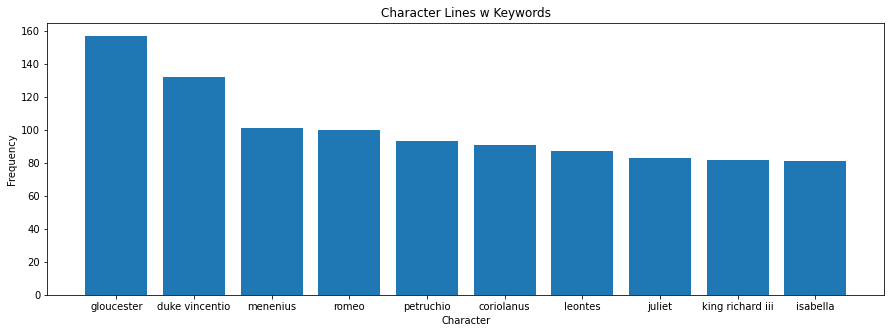

In [25]:
counts_2 = most_common["Speaker"].value_counts()[:10]
counts_2 = pd.DataFrame(counts_2).reset_index().rename(columns={'index':'Speaker', 'Speaker':'Count'})
plt.figure(figsize=(15, 5))
plt.bar("Speaker", "Count", data = counts_2)
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.title("Character Lines w Keywords")
plt.show()


Pretty much the same result in a slightly different order. This doesn't seem like it was a great idea either. A better approach would likely account for how a charcter's speech moves the plot, but not quite sure how to do that here